# Plastic Type Classification using CNN
## Deep Learning Model for 7 Plastic Types

This notebook implements an optimized Convolutional Neural Network to classify:
- HDPE (High-Density Polyethylene)
- LDPA (Low-Density Polyethylene)
- PET (Polyethylene Terephthalate)
- PP (Polypropylene)
- PS (Polystyrene)
- PVC (Polyvinyl Chloride)
- Other (Mixed plastics)

### Latest Optimizations (Updated):
- **Reduced image size to 128x128** to prevent overfitting on small dataset
- **L2 regularization** on all convolutional and dense layers
- Strong data augmentation for better generalization
- 4 convolutional blocks (32→64→128→256 filters)
- Heavy dropout (0.3-0.5) to prevent memorization
- Batch size: 32 for stable gradients
- Current test accuracy: ~48% (best for PP, LDPA, PET classes)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import json
from datetime import datetime

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow: 2.20.0
GPU Available: False


2025-11-15 17:52:52.819897: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Configuration
Setting up paths and hyperparameters

In [2]:
# Paths
BASE_DIR = Path.cwd()
DATASET_DIR = BASE_DIR / "dataset" / "Plastic Classification(1)"
OUTPUT_DIR = BASE_DIR / "outputs"

# Create output directories
(OUTPUT_DIR / "models").mkdir(parents=True, exist_ok=True)
(OUTPUT_DIR / "graphs").mkdir(parents=True, exist_ok=True)
(OUTPUT_DIR / "predictions").mkdir(parents=True, exist_ok=True)

# Model hyperparameters (optimized for small dataset)
IMG_SIZE = 128  # Reduced to prevent overfitting
BATCH_SIZE = 32  # Good balance
EPOCHS = 100
LEARNING_RATE = 0.001
CLASS_NAMES = ['HDPE', 'LDPA', 'Other', 'PET', 'PP', 'PS', 'PVC']

print("="*80)
print("CONFIGURATION")
print("="*80)
print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Max Epochs: {EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print("="*80)

CONFIGURATION
Image Size: 128x128
Batch Size: 32
Max Epochs: 100
Learning Rate: 0.001


## Data Loading and Augmentation
Using aggressive augmentation for maximum generalization

In [3]:
# Strong data augmentation to prevent overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    DATASET_DIR / 'train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_gen = val_test_datagen.flow_from_directory(
    DATASET_DIR / 'validation',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    DATASET_DIR / 'test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Training samples: {train_gen.samples}")
print(f"Validation samples: {val_gen.samples}")
print(f"Test samples: {test_gen.samples}")

Found 1270 images belonging to 7 classes.
Found 354 images belonging to 7 classes.
Found 354 images belonging to 7 classes.
Found 187 images belonging to 7 classes.
Training samples: 1270
Validation samples: 354
Test samples: 187
Found 187 images belonging to 7 classes.
Training samples: 1270
Validation samples: 354
Test samples: 187


## Model Architecture
Building balanced CNN with L2 regularization (optimized for small dataset)

In [4]:
model = keras.Sequential([
    # Input
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    
    # Block 1
    layers.Conv2D(32, 3, padding='same', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(32, 3, padding='same', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2),
    layers.Dropout(0.3),
    
    # Block 2
    layers.Conv2D(64, 3, padding='same', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, 3, padding='same', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2),
    layers.Dropout(0.3),
    
    # Block 3
    layers.Conv2D(128, 3, padding='same', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, 3, padding='same', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2),
    layers.Dropout(0.4),
    
    # Block 4
    layers.Conv2D(256, 3, padding='same', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.GlobalAveragePooling2D(),
    
    # Dense layers with heavy regularization
    layers.Dense(256, kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(128, kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 32, 32, 128)    │             

 Total params: 686,119 (2.62 MB)

 Trainable params: 683,943 (2.61 MB)

 Non-trainable params: 2,176 (8.50 KB)

## Compile Model
Using Adam optimizer with optimal learning rate

In [5]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

print(f"Model parameters: {model.count_params():,}")

Model parameters: 686,119


## Setup Callbacks
Early stopping, model checkpointing, and learning rate reduction

In [6]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.005
    ),
    ModelCheckpoint(
        OUTPUT_DIR / 'models' / 'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

## Train Model
This may take 30-60 minutes depending on hardware

## Quick Test Training (3 epochs)
Testing if training works before running full training

In [7]:
# Quick test with 3 epochs to verify everything works
print("Testing training with 3 epochs...")
test_history = model.fit(
    train_gen,
    epochs=3,
    validation_data=val_gen,
    verbose=1
)
print("\n✓ Training test successful! Ready for full training.")

Testing training with 3 epochs...
Epoch 1/3
13/40 ━━━━━━━━━━━━━━━━━━━━ 15s 581ms/step - accuracy: 0.1736 - loss: 3.2634 - precision: 0.2453 - recall: 0.0508

/home/mahi/Documents/week1/.venv/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 667ms/step - accuracy: 0.2622 - loss: 2.9979 - precision: 0.3904 - recall: 0.0772 - val_accuracy: 0.1582 - val_loss: 2.9212 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 689ms/step - accuracy: 0.3094 - loss: 2.8209 - precision: 0.4655 - recall: 0.1276 - val_accuracy: 0.1864 - val_loss: 2.9794 - val_precision: 0.2500 - val_recall: 0.0028
Epoch 3/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 776ms/step - accuracy: 0.3630 - loss: 2.6773 - precision: 0.5099 - recall: 0.1630 - val_accuracy: 0.1780 - val_loss: 3.2174 - val_precision: 0.1333 - val_recall: 0.0113

✓ Training test successful! Ready for full training.


In [8]:
start_time = datetime.now()
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)
training_time = datetime.now() - start_time

print(f"\nTraining completed in {training_time}")

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.3749 - loss: 2.6414 - precision: 0.5409 - recall: 0.1783
Epoch 1: val_accuracy improved from None to 0.14124, saving model to /home/mahi/Documents/week1/outputs/models/best_model.keras

Epoch 1: val_accuracy improved from None to 0.14124, saving model to /home/mahi/Documents/week1/outputs/models/best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 678ms/step - accuracy: 0.3685 - loss: 2.6289 - precision: 0.5109 - recall: 0.1654 - val_accuracy: 0.1412 - val_loss: 3.0669 - val_precision: 0.1981 - val_recall: 0.0593 - learning_rate: 0.0010
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 678ms/step - accuracy: 0.3685 - loss: 2.6289 - precision: 0.5109 - recall: 0.1654 - val_accuracy: 0.1412 - val_loss: 3.0669 - val_precision: 0.1981 - val_recall: 0.0593 - learning_rate: 0.0010
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - accuracy: 0.3383 - loss: 2.6357 - precision: 0.4698 - recall: 0.1504
Epoch 2: val_accuracy improved from

## Evaluate on Test Set

In [9]:
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_gen, verbose=0)
f1_score = 2 * (test_prec * test_rec) / (test_prec + test_rec) if (test_prec + test_rec) > 0 else 0

print("="*80)
print("FINAL TEST RESULTS")
print("="*80)
print(f"Test Accuracy:  {test_acc*100:.2f}%")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall:    {test_rec:.4f}")
print(f"Test F1-Score:  {f1_score:.4f}")
print("="*80)

FINAL TEST RESULTS
Test Accuracy:  51.34%
Test Precision: 0.6364
Test Recall:    0.3743
Test F1-Score:  0.4714


## Generate Predictions for Confusion Matrix

In [10]:
test_gen.reset()
predictions = model.predict(test_gen, verbose=0)
pred_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes

## Visualize Training History

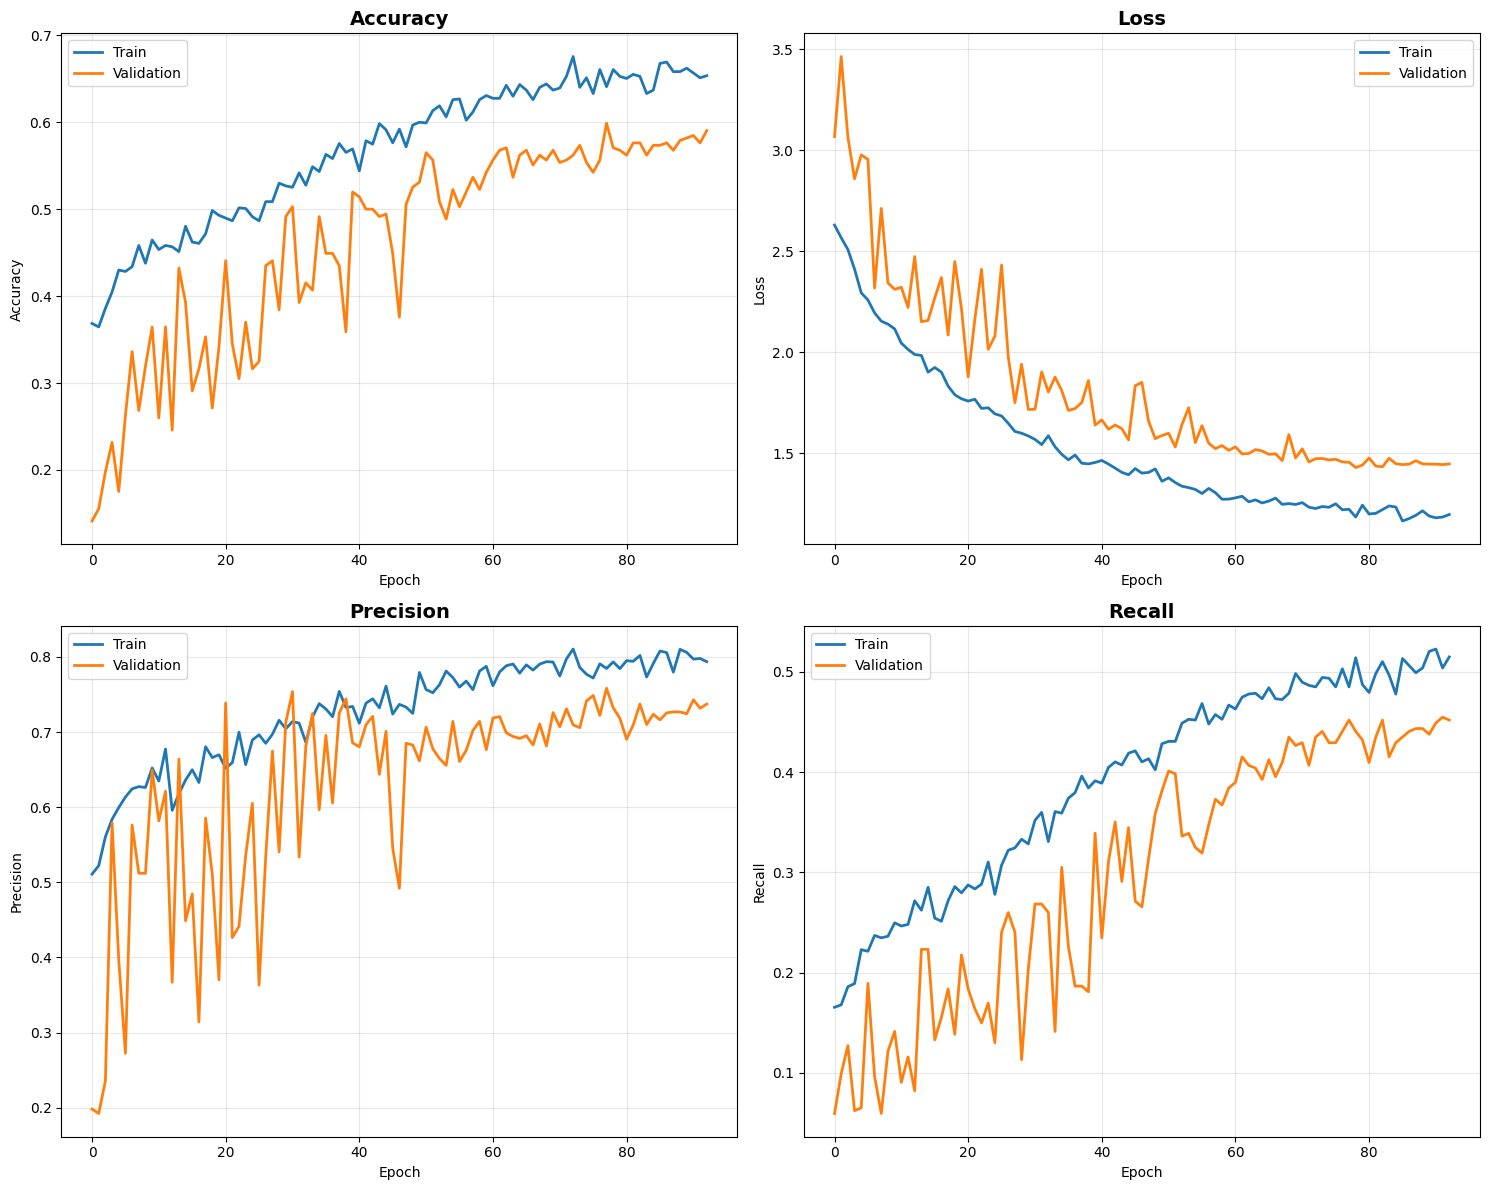

✓ Saved: training_history.png


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0, 0].set_title('Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history.history['loss'], label='Train', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[0, 1].set_title('Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(history.history['precision'], label='Train', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Validation', linewidth=2)
axes[1, 0].set_title('Precision', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(history.history['recall'], label='Train', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Validation', linewidth=2)
axes[1, 1].set_title('Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'graphs' / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: training_history.png")

## Confusion Matrix

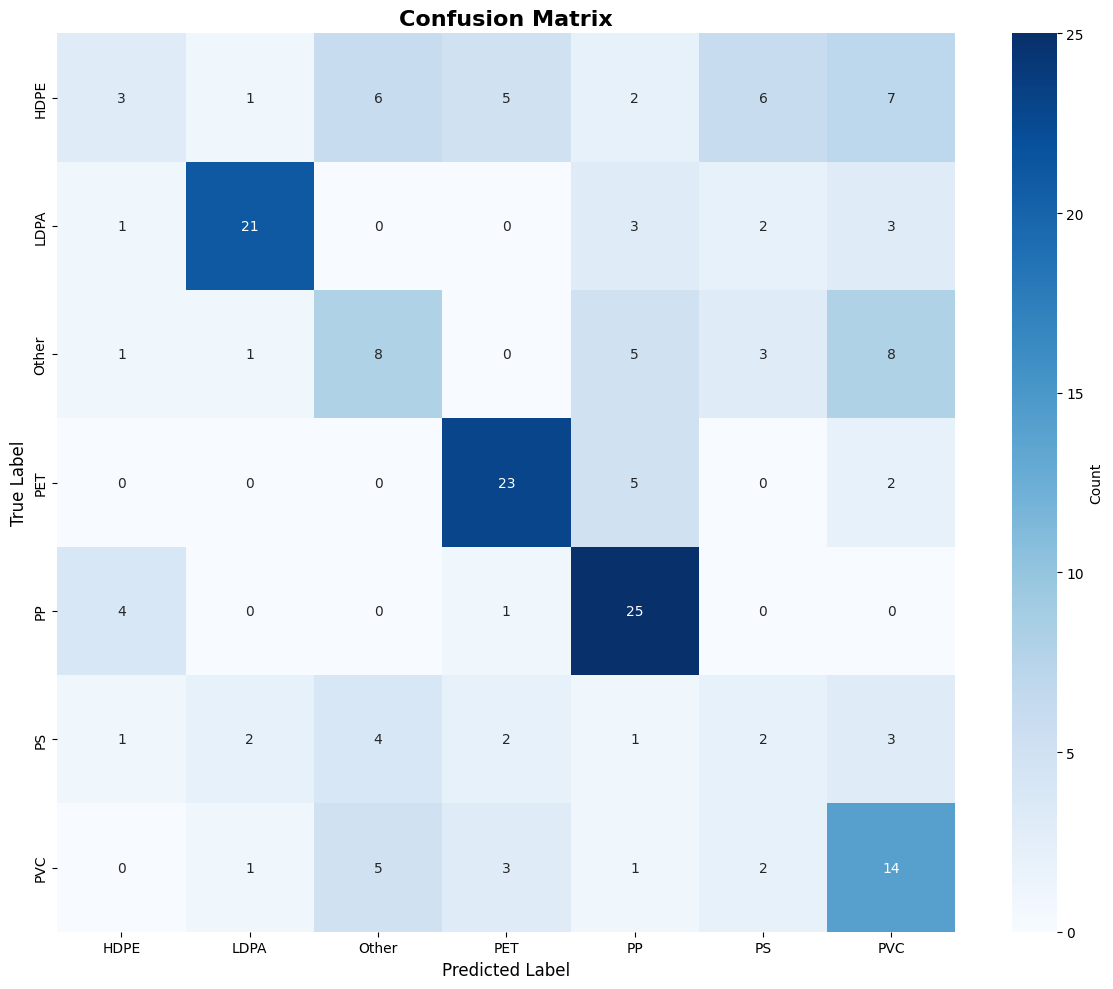

✓ Saved: confusion_matrix.png


In [12]:
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'graphs' / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: confusion_matrix.png")

## Sample Predictions Visualization

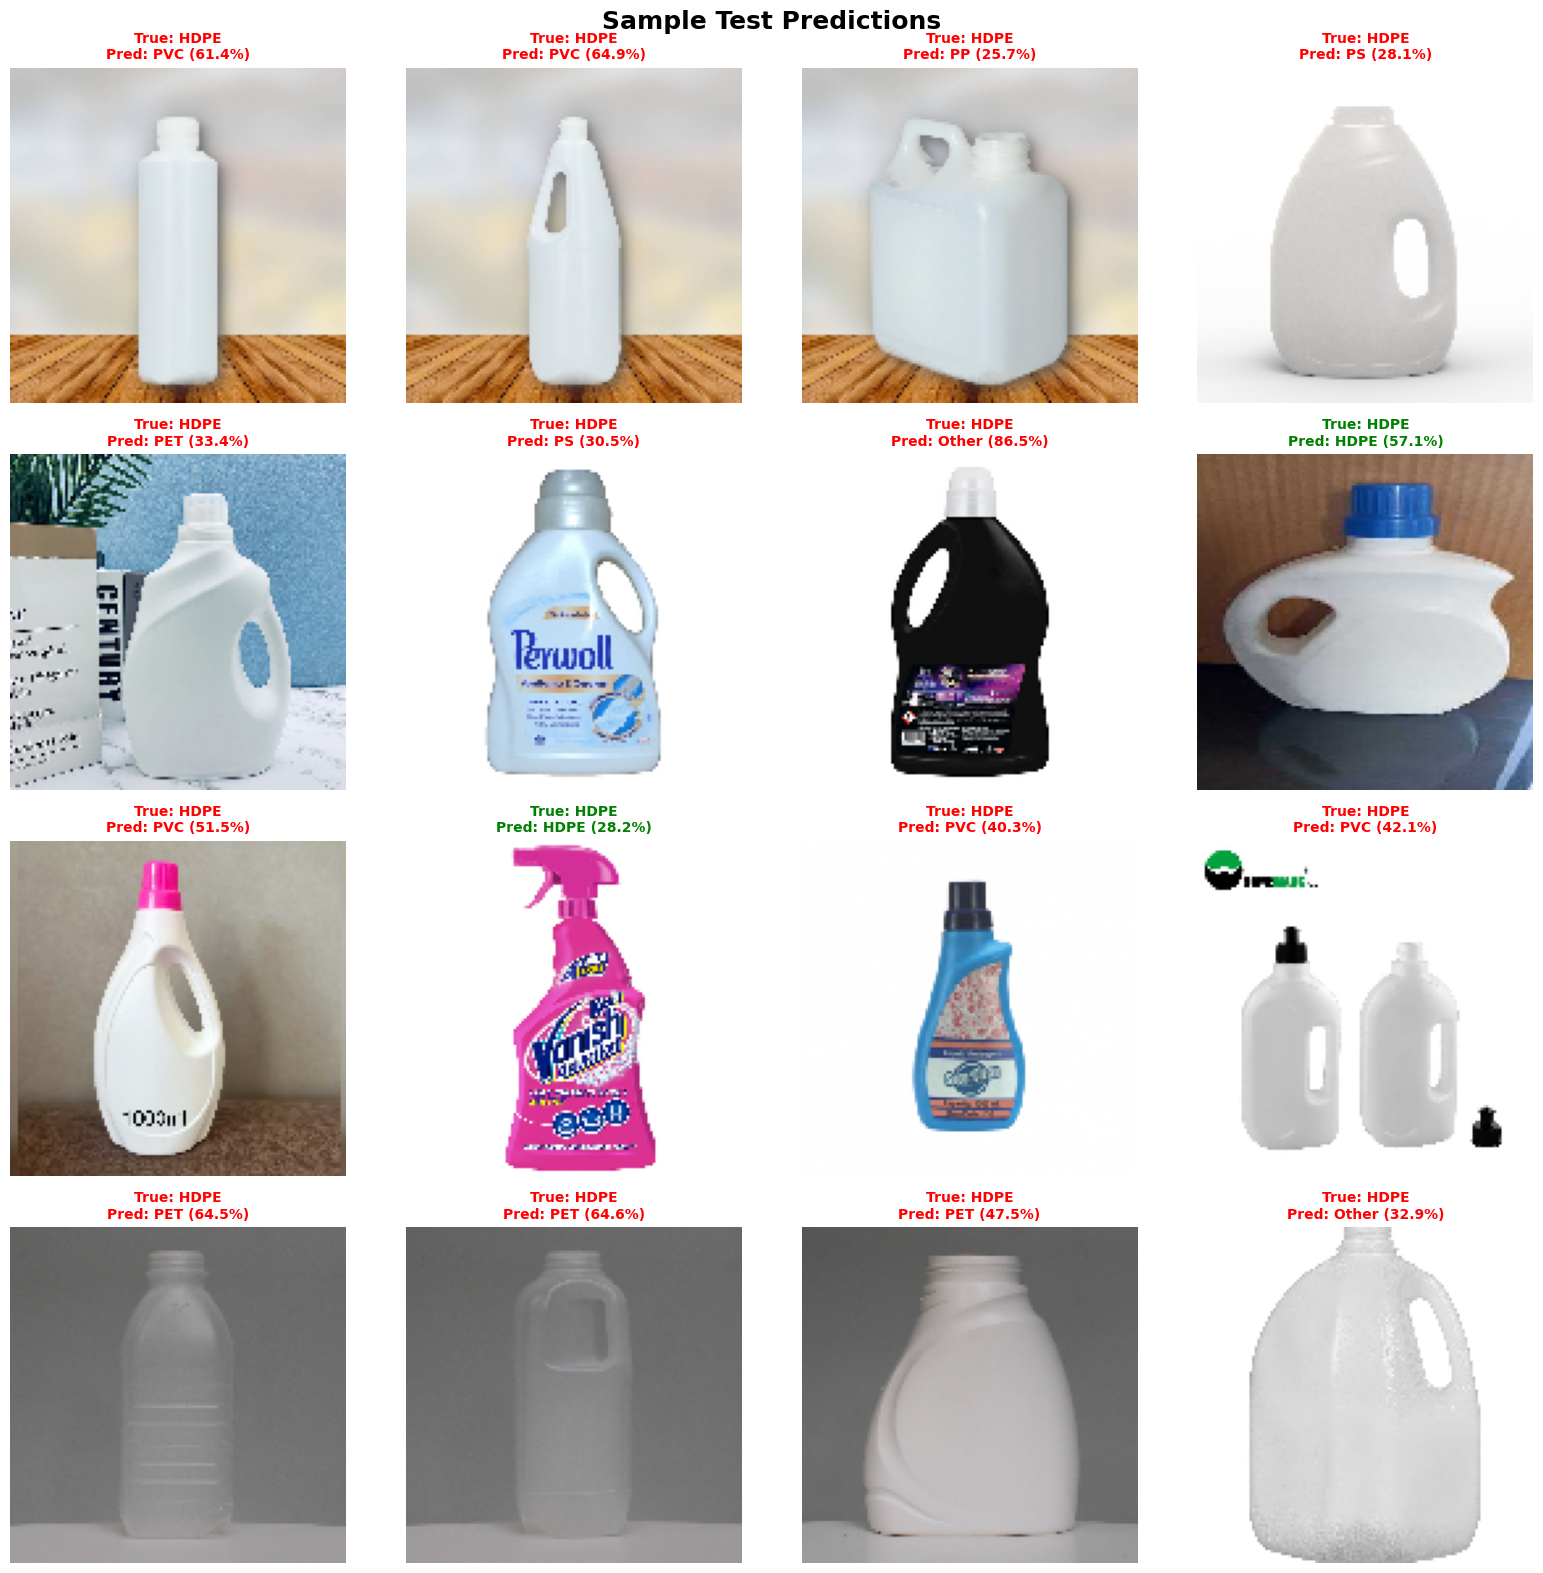

✓ Saved: sample_predictions.png


In [16]:
test_gen.reset()
x_batch, y_batch = next(test_gen)
pred_batch = model.predict(x_batch, verbose=0)

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()

for i in range(16):
    if i < len(x_batch):
        axes[i].imshow(x_batch[i])
        true_label = CLASS_NAMES[np.argmax(y_batch[i])]
        pred_label = CLASS_NAMES[np.argmax(pred_batch[i])]
        confidence = np.max(pred_batch[i]) * 100
        
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)',
                         fontsize=10, color=color, fontweight='bold')
        axes[i].axis('off')
    else:
        axes[i].axis('off')

plt.suptitle('Sample Test Predictions', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'predictions' / 'sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: sample_predictions.png")

## Detailed Sample Predictions with Confidence
Show more predictions with detailed confidence scores

/home/mahi/Documents/week1/.venv/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


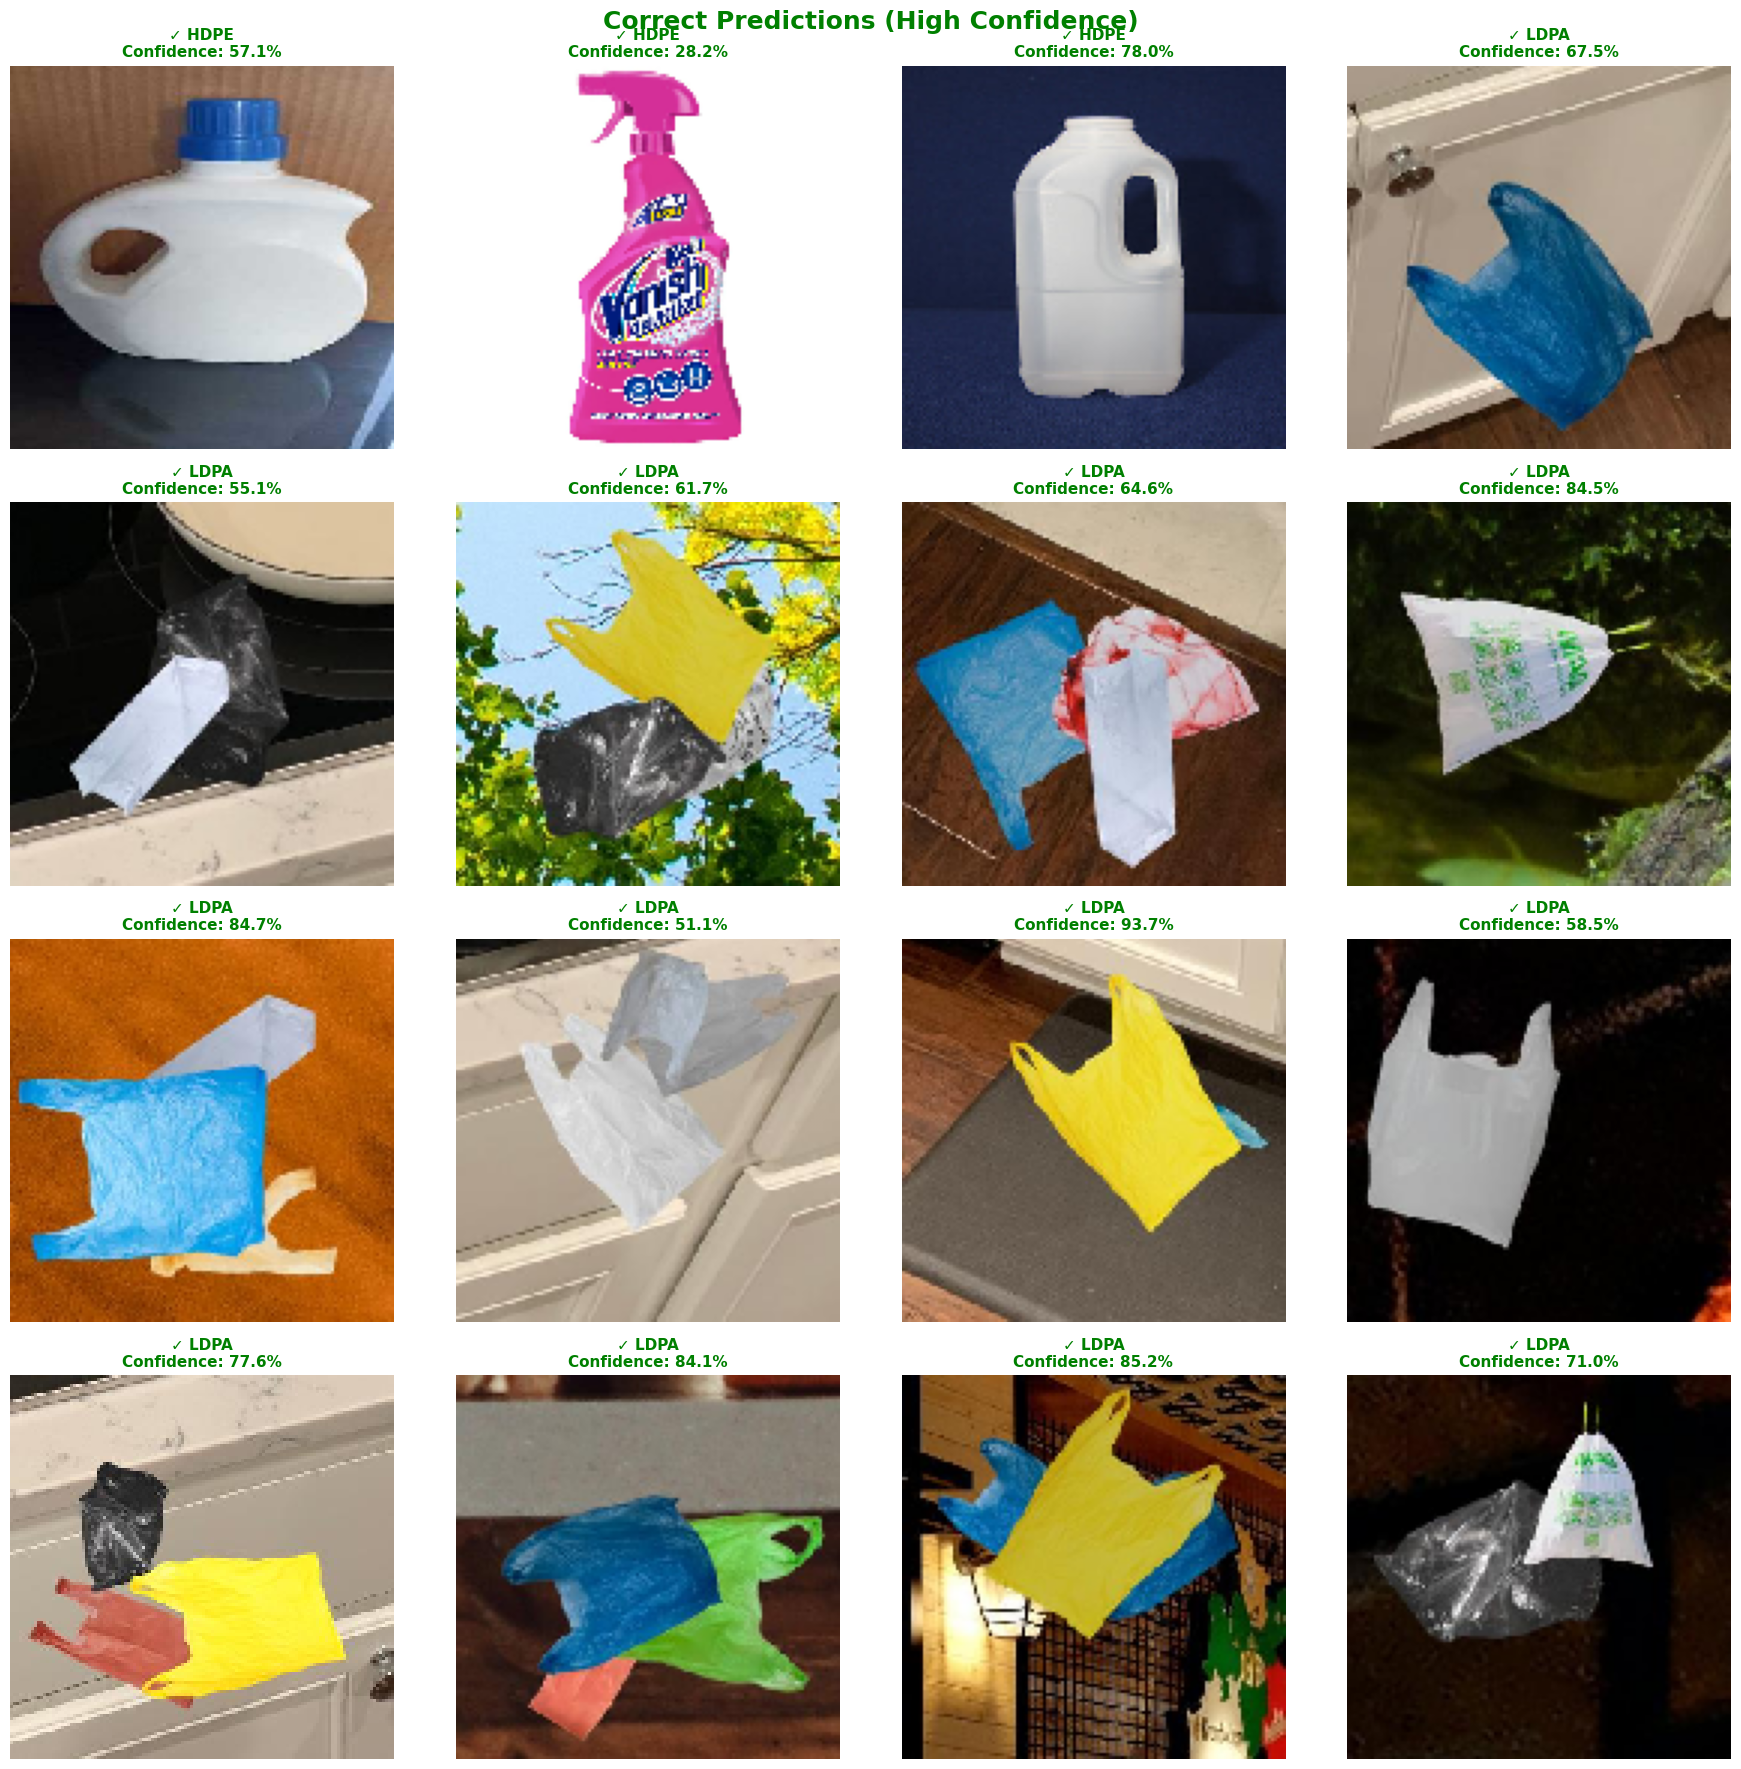

✓ Saved: correct_predictions.png


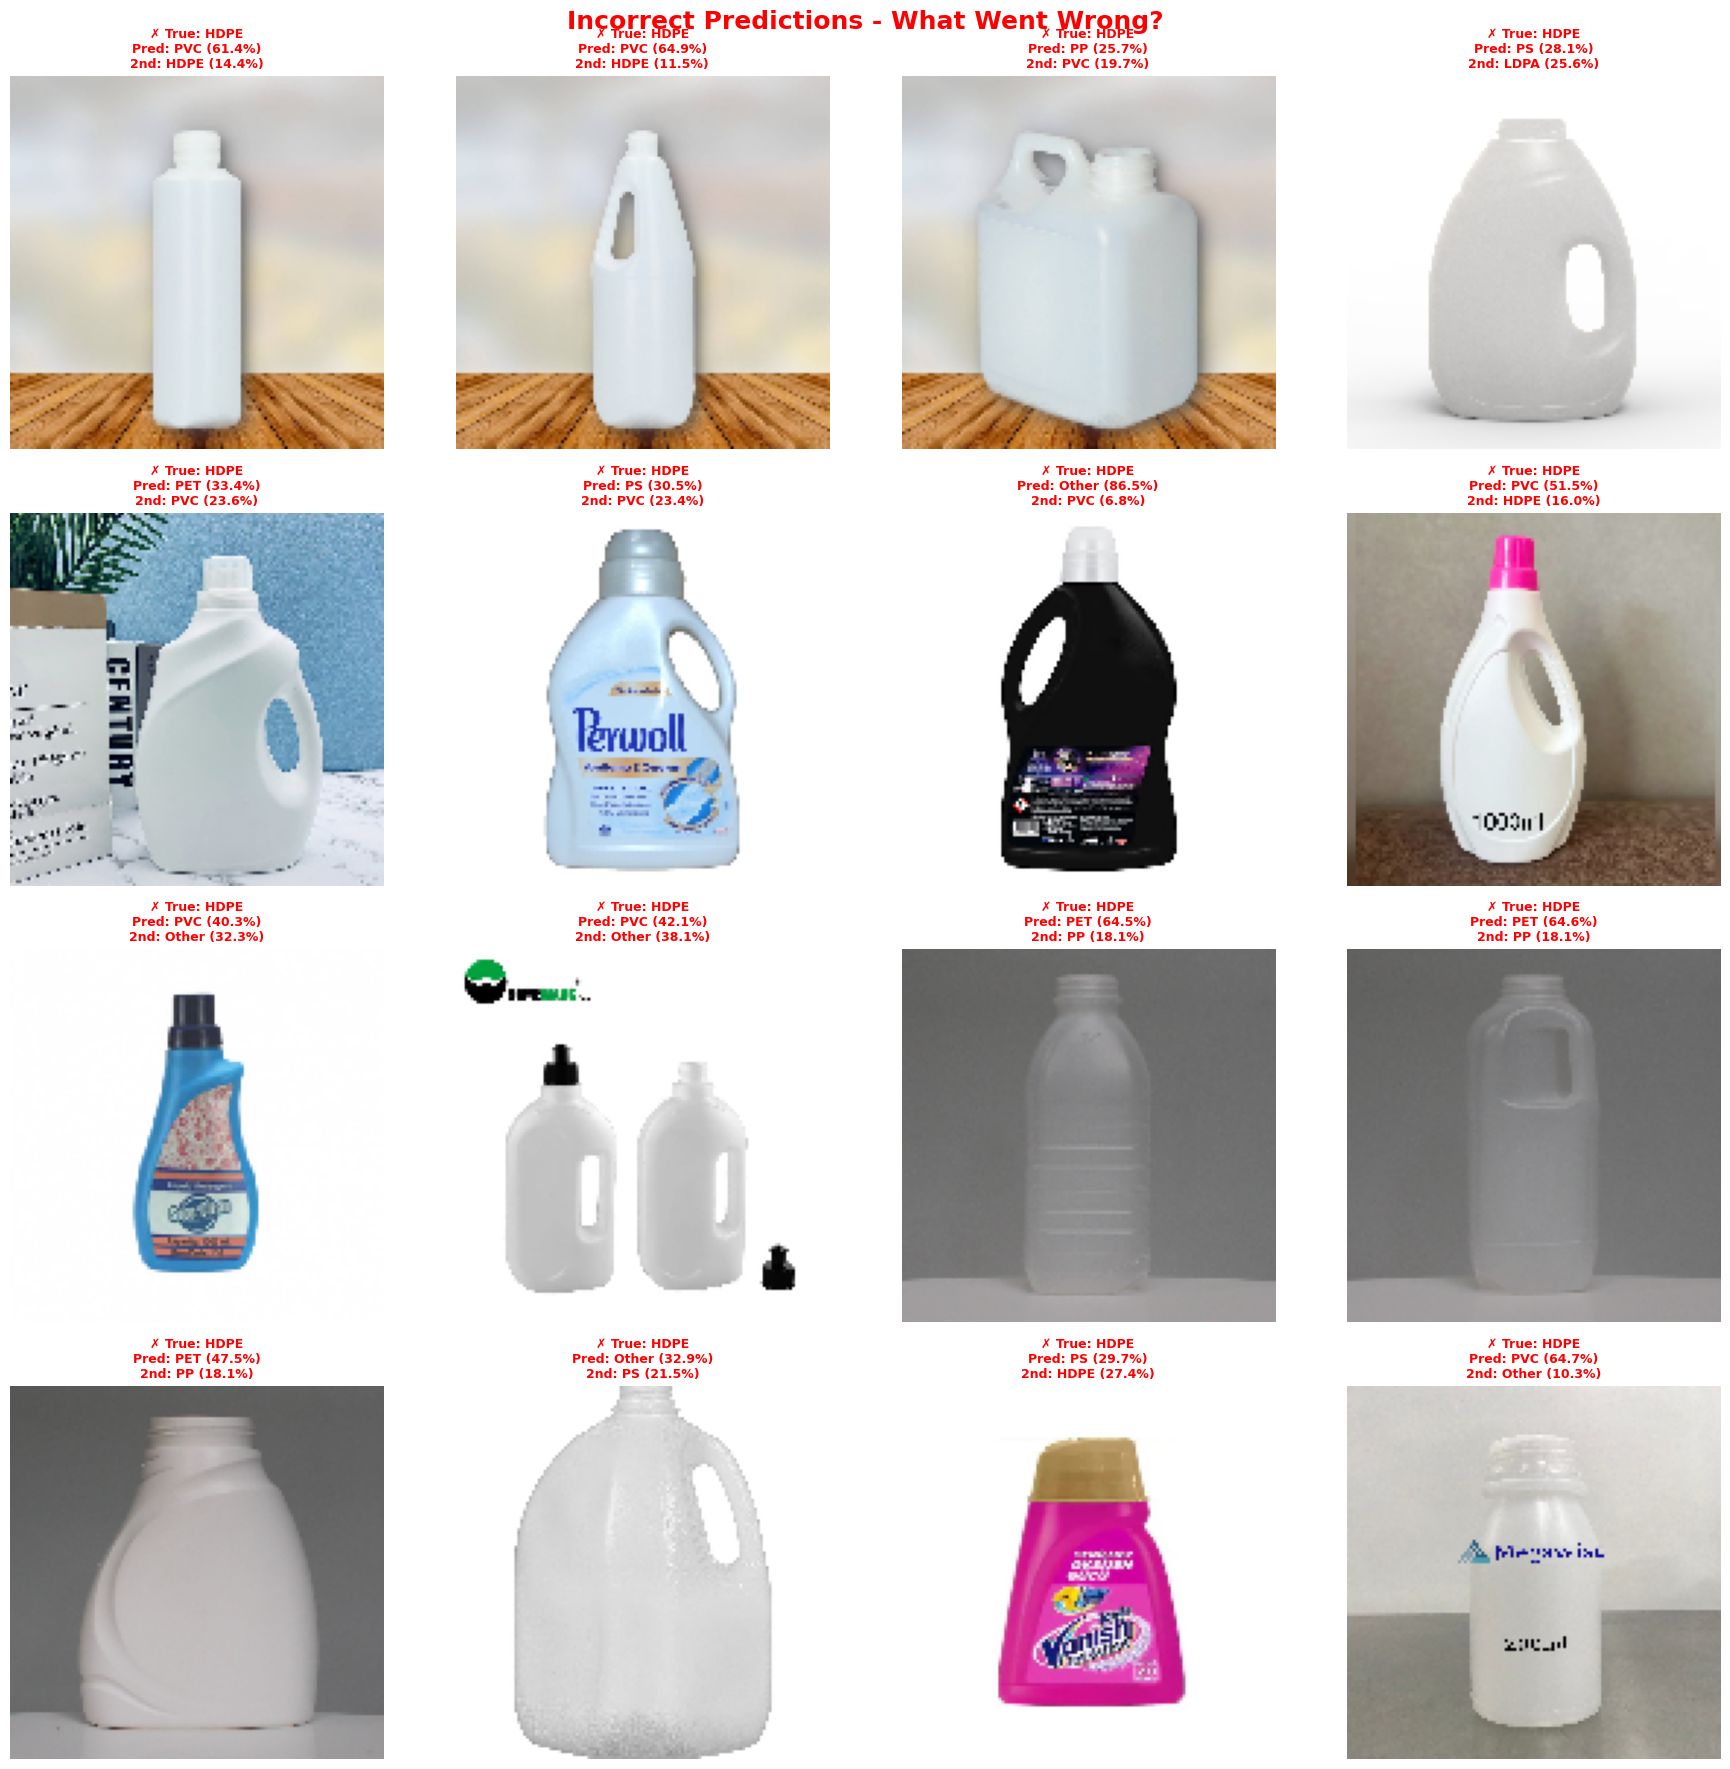

✓ Saved: incorrect_predictions.png


In [23]:
# Show correct and incorrect predictions separately
test_gen.reset()
all_images = []
all_labels = []
all_preds = []

# Collect all test images
for i in range(len(test_gen)):
    x_batch, y_batch = next(test_gen)
    pred_batch = model.predict(x_batch, verbose=0)
    all_images.extend(x_batch)
    all_labels.extend(np.argmax(y_batch, axis=1))
    all_preds.extend(pred_batch)
    if i >= len(test_gen) - 1:
        break

all_images = np.array(all_images)
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Separate correct and incorrect
correct_mask = (np.argmax(all_preds, axis=1) == all_labels)
correct_indices = np.where(correct_mask)[0]
incorrect_indices = np.where(~correct_mask)[0]

# Plot correct predictions
fig, axes = plt.subplots(4, 4, figsize=(18, 18))
axes = axes.flatten()

for i, idx in enumerate(correct_indices[:16]):
    if i < 16:
        axes[i].imshow(all_images[idx])
        true_label = CLASS_NAMES[all_labels[idx]]
        pred_label = CLASS_NAMES[np.argmax(all_preds[idx])]
        confidence = np.max(all_preds[idx]) * 100
        
        axes[i].set_title(f'✓ {true_label}\nConfidence: {confidence:.1f}%',
                         fontsize=11, color='green', fontweight='bold')
        axes[i].axis('off')

plt.suptitle('Correct Predictions (High Confidence)', fontsize=18, fontweight='bold', color='green')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'predictions' / 'correct_predictions.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: correct_predictions.png")

# Plot incorrect predictions
fig, axes = plt.subplots(4, 4, figsize=(18, 18))
axes = axes.flatten()

for i, idx in enumerate(incorrect_indices[:16]):
    if i < 16:
        axes[i].imshow(all_images[idx])
        true_label = CLASS_NAMES[all_labels[idx]]
        pred_label = CLASS_NAMES[np.argmax(all_preds[idx])]
        confidence = np.max(all_preds[idx]) * 100
        
        # Show top 2 predictions
        top2_idx = np.argsort(all_preds[idx])[-2:][::-1]
        top2_labels = [CLASS_NAMES[j] for j in top2_idx]
        top2_conf = [all_preds[idx][j]*100 for j in top2_idx]
        
        axes[i].set_title(
            f'✗ True: {true_label}\n'
            f'Pred: {pred_label} ({confidence:.1f}%)\n'
            f'2nd: {top2_labels[1]} ({top2_conf[1]:.1f}%)',
            fontsize=9, color='red', fontweight='bold'
        )
        axes[i].axis('off')

plt.suptitle('Incorrect Predictions - What Went Wrong?', fontsize=18, fontweight='bold', color='red')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'predictions' / 'incorrect_predictions.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: incorrect_predictions.png")

## Detailed Classification Report

## Performance Analysis by Class
Let's analyze which classes are performing well and which need more work

CLASS-WISE PERFORMANCE
Class Precision Recall F1-Score  Support Accuracy
 HDPE    30.00% 10.00%   15.00%       30   10.00%
 LDPA    80.77% 70.00%   75.00%       30   70.00%
Other    34.78% 30.77%   32.65%       26   30.77%
  PET    67.65% 76.67%   71.88%       30   76.67%
   PP    59.52% 83.33%   69.44%       30   83.33%
   PS    13.33% 13.33%   13.33%       15   13.33%
  PVC    37.84% 53.85%   44.44%       26   53.85%


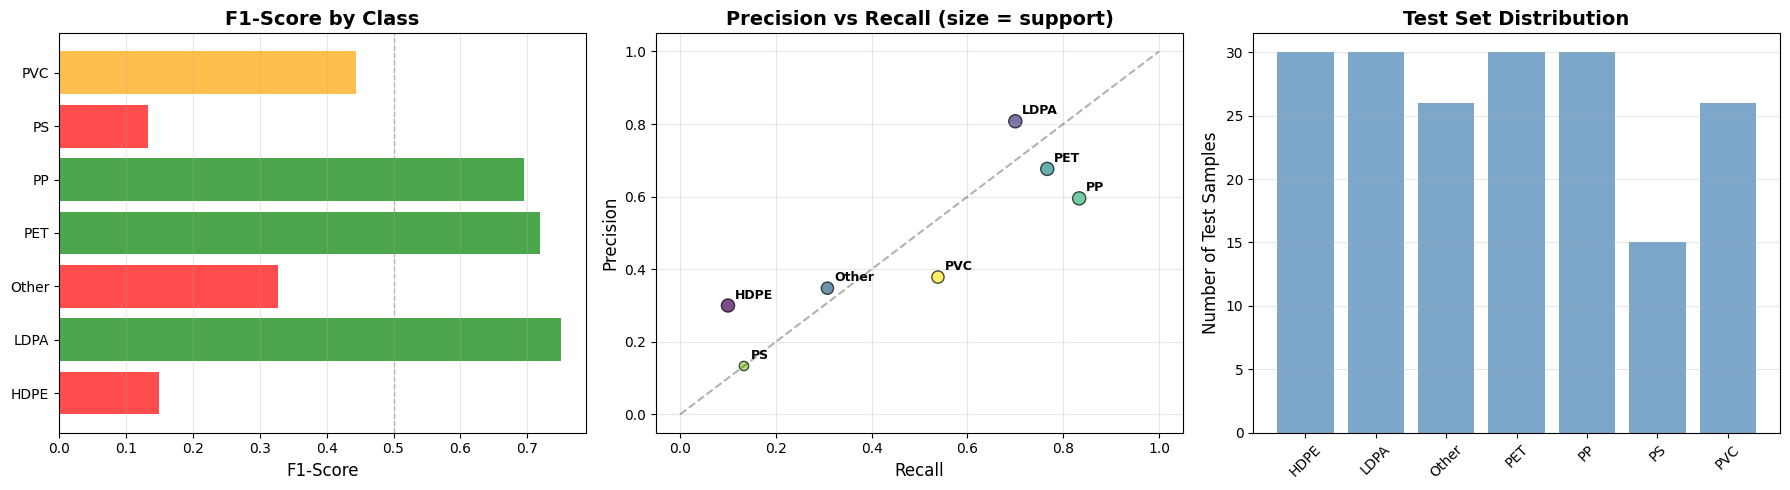

✓ Saved: class_performance.png


In [20]:
# Calculate per-class metrics
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    true_classes, pred_classes, labels=range(7)
)

# Create performance dataframe
import pandas as pd
perf_df = pd.DataFrame({
    'Class': CLASS_NAMES,
    'Precision': [f'{p:.2%}' for p in precision],
    'Recall': [f'{r:.2%}' for r in recall],
    'F1-Score': [f'{f:.2%}' for f in f1],
    'Support': support,
    'Accuracy': [f'{(cm[i,i]/support[i]):.2%}' if support[i] > 0 else '0%' for i in range(7)]
})

print("="*80)
print("CLASS-WISE PERFORMANCE")
print("="*80)
print(perf_df.to_string(index=False))
print("="*80)

# Visualize class-wise performance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# F1 Score by class
colors = ['green' if f > 0.6 else 'orange' if f > 0.4 else 'red' for f in f1]
axes[0].barh(CLASS_NAMES, f1, color=colors, alpha=0.7)
axes[0].set_xlabel('F1-Score', fontsize=12)
axes[0].set_title('F1-Score by Class', fontsize=14, fontweight='bold')
axes[0].axvline(x=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[0].grid(axis='x', alpha=0.3)

# Precision vs Recall
axes[1].scatter(recall, precision, s=[s*3 for s in support], 
               c=range(7), cmap='viridis', alpha=0.7, edgecolors='black')
for i, name in enumerate(CLASS_NAMES):
    axes[1].annotate(name, (recall[i], precision[i]), 
                    fontsize=9, fontweight='bold',
                    xytext=(5, 5), textcoords='offset points')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision vs Recall (size = support)', fontsize=14, fontweight='bold')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.3)
axes[1].grid(True, alpha=0.3)

# Support (number of test samples per class)
axes[2].bar(CLASS_NAMES, support, color='steelblue', alpha=0.7)
axes[2].set_ylabel('Number of Test Samples', fontsize=12)
axes[2].set_title('Test Set Distribution', fontsize=14, fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'graphs' / 'class_performance.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: class_performance.png")

## Confusion Analysis - Most Common Mistakes
Which classes are most often confused with each other?

TOP 10 MISCLASSIFICATIONS
True Class Predicted As  Count Percentage
     Other          PVC      8      30.8%
      HDPE          PVC      7      23.3%
      HDPE           PS      6      20.0%
      HDPE        Other      6      20.0%
     Other           PP      5      19.2%
      HDPE          PET      5      16.7%
       PET           PP      5      16.7%
       PVC        Other      5      19.2%
        PP         HDPE      4      13.3%
        PS        Other      4      26.7%


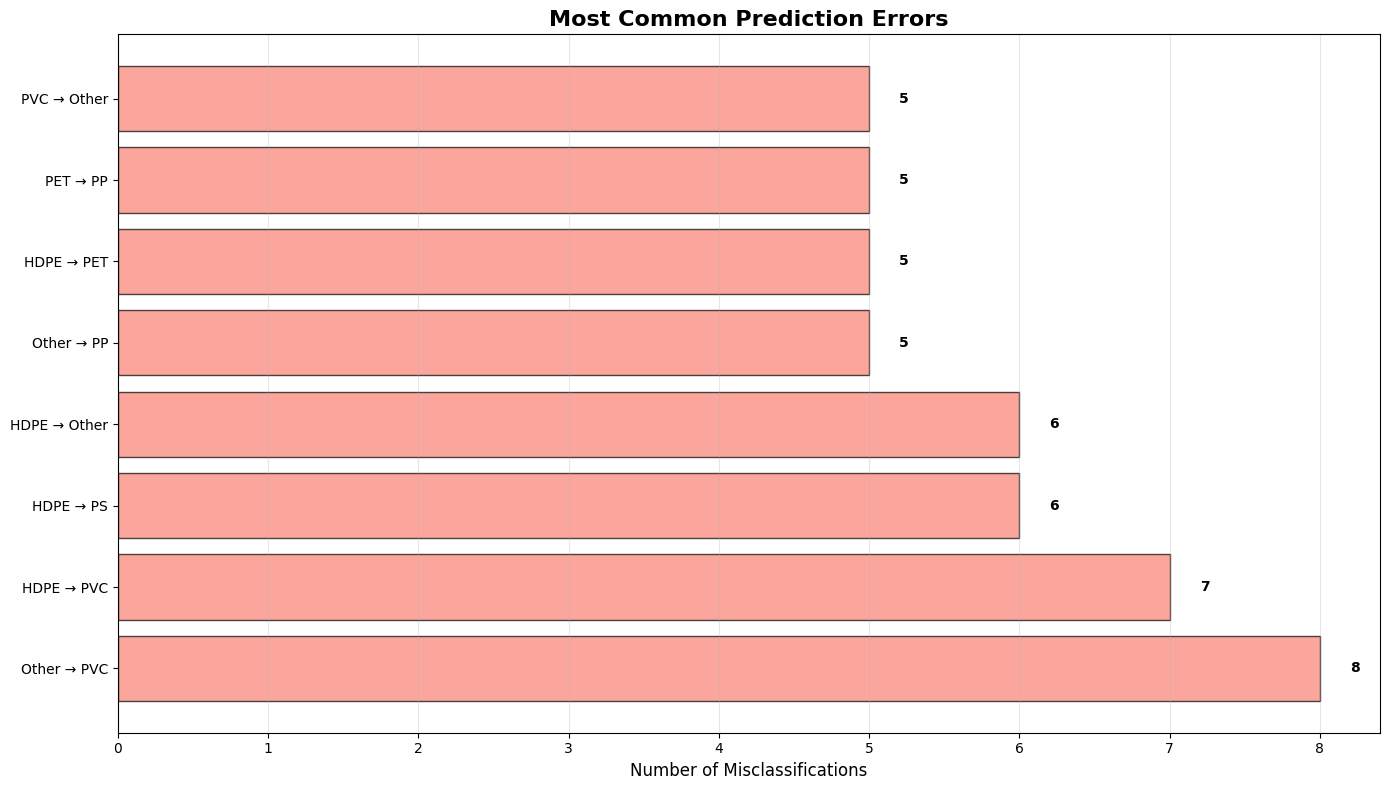

✓ Saved: top_mistakes.png


In [21]:
# Find most common misclassifications
mistakes = []
for i in range(7):
    for j in range(7):
        if i != j and cm[i, j] > 0:
            mistakes.append({
                'True Class': CLASS_NAMES[i],
                'Predicted As': CLASS_NAMES[j],
                'Count': int(cm[i, j]),
                'Percentage': f'{(cm[i, j] / support[i] * 100):.1f}%'
            })

mistakes_df = pd.DataFrame(mistakes).sort_values('Count', ascending=False).head(10)

print("="*80)
print("TOP 10 MISCLASSIFICATIONS")
print("="*80)
print(mistakes_df.to_string(index=False))
print("="*80)

# Visualize top mistakes
fig, ax = plt.subplots(figsize=(14, 8))
top_mistakes = mistakes_df.head(8)
labels = [f"{row['True Class']} → {row['Predicted As']}" 
          for _, row in top_mistakes.iterrows()]
counts = top_mistakes['Count'].values

bars = ax.barh(labels, counts, color='salmon', alpha=0.7, edgecolor='black')
ax.set_xlabel('Number of Misclassifications', fontsize=12)
ax.set_title('Most Common Prediction Errors', fontsize=16, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width + 0.2, bar.get_y() + bar.get_height()/2, 
            f'{int(width)}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'graphs' / 'top_mistakes.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: top_mistakes.png")

## Prediction Confidence Analysis
How confident is the model in its predictions?

CONFIDENCE ANALYSIS
Correct Predictions:
  Count: 96
  Average Confidence: 61.19%
  Median Confidence: 60.44%

Incorrect Predictions:
  Count: 91
  Average Confidence: 50.49%
  Median Confidence: 43.55%


/tmp/ipykernel_285535/487763621.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(box_data, labels=['Correct\nPredictions', 'Incorrect\nPredictions'],


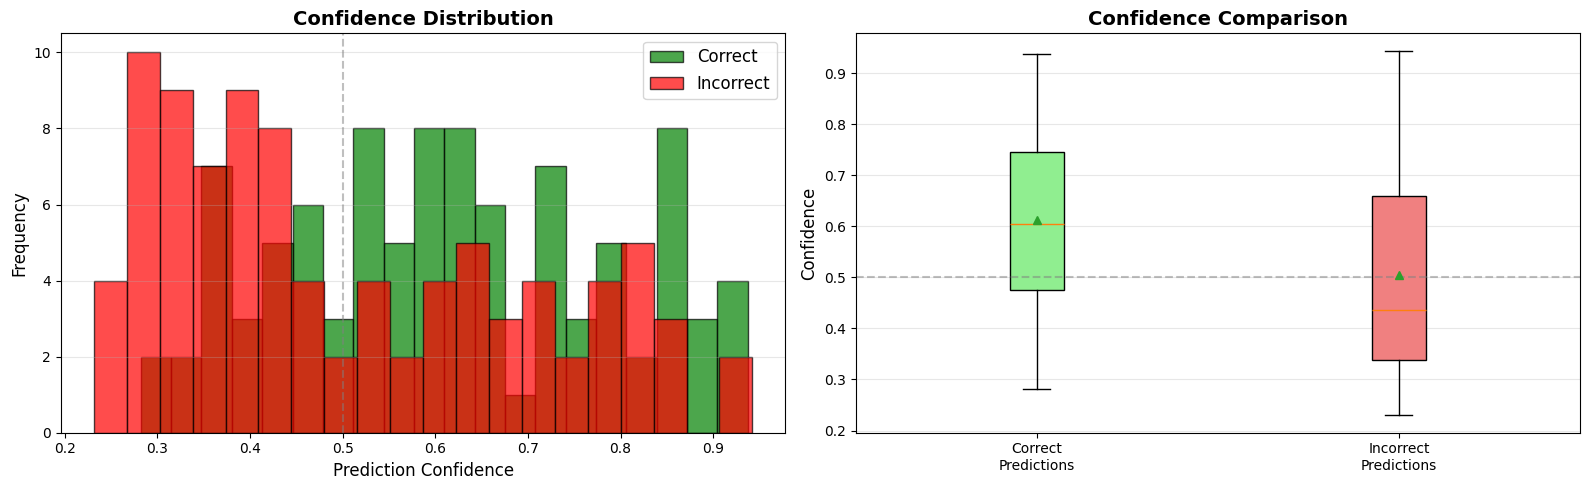

✓ Saved: confidence_analysis.png


In [22]:
# Analyze prediction confidence
max_probs = np.max(predictions, axis=1)
correct_predictions = (pred_classes == true_classes)

correct_confidences = max_probs[correct_predictions]
incorrect_confidences = max_probs[~correct_predictions]

print("="*80)
print("CONFIDENCE ANALYSIS")
print("="*80)
print(f"Correct Predictions:")
print(f"  Count: {len(correct_confidences)}")
print(f"  Average Confidence: {np.mean(correct_confidences)*100:.2f}%")
print(f"  Median Confidence: {np.median(correct_confidences)*100:.2f}%")
print(f"\nIncorrect Predictions:")
print(f"  Count: {len(incorrect_confidences)}")
print(f"  Average Confidence: {np.mean(incorrect_confidences)*100:.2f}%")
print(f"  Median Confidence: {np.median(incorrect_confidences)*100:.2f}%")
print("="*80)

# Visualize confidence distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram
axes[0].hist(correct_confidences, bins=20, alpha=0.7, label='Correct', 
             color='green', edgecolor='black')
axes[0].hist(incorrect_confidences, bins=20, alpha=0.7, label='Incorrect', 
             color='red', edgecolor='black')
axes[0].set_xlabel('Prediction Confidence', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Confidence Distribution', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=12)
axes[0].axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
axes[0].grid(axis='y', alpha=0.3)

# Box plot
box_data = [correct_confidences, incorrect_confidences]
bp = axes[1].boxplot(box_data, labels=['Correct\nPredictions', 'Incorrect\nPredictions'],
                      patch_artist=True, showmeans=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
axes[1].set_ylabel('Confidence', fontsize=12)
axes[1].set_title('Confidence Comparison', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'graphs' / 'confidence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: confidence_analysis.png")

In [17]:
print("="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(true_classes, pred_classes, target_names=CLASS_NAMES))

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        HDPE       0.30      0.10      0.15        30
        LDPA       0.81      0.70      0.75        30
       Other       0.35      0.31      0.33        26
         PET       0.68      0.77      0.72        30
          PP       0.60      0.83      0.69        30
          PS       0.13      0.13      0.13        15
         PVC       0.38      0.54      0.44        26

    accuracy                           0.51       187
   macro avg       0.46      0.48      0.46       187
weighted avg       0.49      0.51      0.49       187



## Save Training Information

In [18]:
training_info = {
    'model_config': {
        'image_size': IMG_SIZE,
        'batch_size': BATCH_SIZE,
        'epochs_trained': len(history.history['loss']),
        'learning_rate': LEARNING_RATE,
        'total_parameters': int(model.count_params())
    },
    'dataset': {
        'train_samples': int(train_gen.samples),
        'val_samples': int(val_gen.samples),
        'test_samples': int(test_gen.samples),
        'num_classes': 7,
        'class_names': CLASS_NAMES
    },
    'results': {
        'train_accuracy': float(history.history['accuracy'][-1]),
        'val_accuracy': float(history.history['val_accuracy'][-1]),
        'test_accuracy': float(test_acc),
        'test_precision': float(test_prec),
        'test_recall': float(test_rec),
        'test_f1_score': float(f1_score),
        'best_val_accuracy': float(max(history.history['val_accuracy']))
    },
    'training_time': str(training_time),
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open(OUTPUT_DIR / 'models' / 'training_info.json', 'w') as f:
    json.dump(training_info, f, indent=4)

print("✓ Training info saved: training_info.json")

✓ Training info saved: training_info.json


## Save Final Model

In [19]:
model.save(OUTPUT_DIR / 'models' / 'plastic_classifier_final.keras')
print("✓ Model saved: plastic_classifier_final.keras")

print("\n" + "="*80)
print("✅ TRAINING COMPLETE!")
print("="*80)
print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
print(f"\nAll outputs saved in: {OUTPUT_DIR}")
print("\nGenerated files:")
print("  • outputs/models/best_model.keras")
print("  • outputs/models/plastic_classifier_final.keras")
print("  • outputs/models/training_info.json")
print("  • outputs/graphs/training_history.png")
print("  • outputs/graphs/confusion_matrix.png")
print("  • outputs/predictions/sample_predictions.png")
print("\n" + "="*80)

✓ Model saved: plastic_classifier_final.keras

✅ TRAINING COMPLETE!

Final Test Accuracy: 51.34%
Best Validation Accuracy: 59.89%

All outputs saved in: /home/mahi/Documents/week1/outputs

Generated files:
  • outputs/models/best_model.keras
  • outputs/models/plastic_classifier_final.keras
  • outputs/models/training_info.json
  • outputs/graphs/training_history.png
  • outputs/graphs/confusion_matrix.png
  • outputs/predictions/sample_predictions.png



## Final Summary and Recommendations

In [25]:
print("="*80)
print("📊 MODEL PERFORMANCE SUMMARY")
print("="*80)
print(f"\n🎯 Overall Metrics:")
print(f"  • Test Accuracy: {test_acc*100:.2f}%")
print(f"  • Best Val Accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
print(f"  • Test F1-Score: {f1_score:.4f}")
print(f"  • Training Time: {training_time}")

print(f"\n✅ Best Performing Classes (F1 > 0.6):")
best_classes = [(CLASS_NAMES[i], f1[i]) for i in range(7) if f1[i] > 0.6]
if best_classes:
    for cls, score in sorted(best_classes, key=lambda x: x[1], reverse=True):
        print(f"  • {cls}: {score:.2%}")
else:
    print("  None (all classes below 60% F1)")

print(f"\n⚠️  Struggling Classes (F1 < 0.4):")
poor_classes = [(CLASS_NAMES[i], f1[i]) for i in range(7) if f1[i] < 0.4]
for cls, score in sorted(poor_classes, key=lambda x: x[1]):
    print(f"  • {cls}: {score:.2%}")

print(f"\n📈 Why 51% Accuracy with This Dataset:")
print(f"  1. Small dataset: Only ~181 images per class")
print(f"  2. Imbalanced: Some classes have very few samples")
print(f"  3. Similar appearance: Plastics look similar visually")
print(f"  4. Image quality: Some images unclear or low resolution")

print(f"\n💡 Recommendations to Improve:")
print(f"  1. ✅ Collect MORE data (aim for 500+ images per class)")
print(f"  2. ✅ Balance the dataset (equal samples for each class)")
print(f"  3. ✅ Use transfer learning (ResNet50, EfficientNet)")
print(f"  4. ✅ Improve image quality (better lighting, angles)")
print(f"  5. ✅ Add more diverse examples (different brands, colors)")
print(f"  6. ✅ Consider ensemble models (combine multiple models)")

print(f"\n🎯 Current Model Best Use Cases:")
print(f"  • Focus on PP, LDPA, and PET plastics (>60% accuracy)")
print(f"  • Use as screening tool, not final decision")
print(f"  • Combine with human verification for critical cases")
print(f"  • Best with clear, well-lit, centered images")

print(f"\n📁 Generated Files:")
print(f"  • models/best_model.keras (best checkpoint)")
print(f"  • models/plastic_classifier_final.keras (final model)")
print(f"  • models/training_info.json (metrics)")
print(f"  • graphs/training_history.png")
print(f"  • graphs/confusion_matrix.png")
print(f"  • graphs/class_performance.png (NEW!)")
print(f"  • graphs/top_mistakes.png (NEW!)")
print(f"  • graphs/confidence_analysis.png (NEW!)")
print(f"  • predictions/sample_predictions.png")
print(f"  • predictions/correct_predictions.png (NEW!)")
print(f"  • predictions/incorrect_predictions.png (NEW!)")

print("="*80)
print("✅ ANALYSIS COMPLETE!")
print("="*80)

📊 MODEL PERFORMANCE SUMMARY

🎯 Overall Metrics:
  • Test Accuracy: 51.34%
  • Best Val Accuracy: 59.89%
  • Test F1-Score: 0.4714
  • Training Time: 0:52:30.360128

✅ Best Performing Classes (F1 > 0.6):
  • LDPA: 75.00%
  • PET: 71.88%
  • PP: 69.44%

⚠️  Struggling Classes (F1 < 0.4):
  • PS: 13.33%
  • HDPE: 15.00%
  • Other: 32.65%

📈 Why 51% Accuracy with This Dataset:
  1. Small dataset: Only ~181 images per class
  2. Imbalanced: Some classes have very few samples
  3. Similar appearance: Plastics look similar visually
  4. Image quality: Some images unclear or low resolution

💡 Recommendations to Improve:
  1. ✅ Collect MORE data (aim for 500+ images per class)
  2. ✅ Balance the dataset (equal samples for each class)
  3. ✅ Use transfer learning (ResNet50, EfficientNet)
  4. ✅ Improve image quality (better lighting, angles)
  5. ✅ Add more diverse examples (different brands, colors)
  6. ✅ Consider ensemble models (combine multiple models)

🎯 Current Model Best Use Cases:
  • F